# Finding Weights Analytically

This notebook is split in two halves.

The first half aims to verify the framework for cumulant propagation as in the paper 'Decomposing Neural Networks as Mappings of Correlation Functions' by Fischer et al., 2022.

The notebook then contains code to simplify finding tensor contractions of the input cumulants with the relevant weights matrices. This is useful as it simplifies the process of generating a sufficient set of equations for the specific network architecture being considerd, which can then be solved for the weights, using the fact that we know how the cumulants transform by considering the distribution recursion relation $$p_{n+1}(x) = \sqrt{2} \int \mathrm{d}y \, p_n(\sqrt{2}x - y) \, p_n(y) = (\mathscr{R} p_n)(x).$$

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random

import torch.nn.functional as F
from scipy.stats import norm

from mpl_toolkits.mplot3d import Axes3D


# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
%matplotlib widget

# Fisher Framework Verification

Checking that the Fischer framework is consistent with the expected cumulant transformtion, for this Central Limit Theorem example considered.

## Extract weights from CLT_Fisher.ipynb

In [2]:
# Load the saved weights from the file
model_weights = torch.load('CLT_Fisher_model_weights.pth')

# Dictionary to store extracted weight matrices
extracted_weights = {}
for name, weight in model_weights.items():
    if 'weight' in name:
        extracted_weights[name] = weight.detach().cpu().numpy()
weight_1 = extracted_weights['non_linear_activ.0.weight']
weight_2 = extracted_weights['non_linear_activ.2.weight']

# Display the extracted weights
print("Extracted Weights:\n")
for name, weight in extracted_weights.items():
    print(f"Name: {name}")
    print(f"Shape: {weight.shape}")
    print(weight)
    print("\n----------\n")

alpha = 0.5

FileNotFoundError: [Errno 2] No such file or directory: 'CLT_Fisher_model_weights.pth'

## One hidden layer with quadratic nonlinearity

In [6]:
# Input
input_mean = np.sqrt(2) * np.array([1, 1])
input_cov = 50*np.array([[1, 0], [0, 1]])

# Affine 1
mu_z = np.matmul(weight_1, input_mean)
cov_z = np.matmul(np.matmul(weight_1, input_cov), weight_1.T)

# Nonlinearity
mu_y = mu_z + alpha * (np.square(mu_z) + np.diag(cov_z))

dim = mu_z.shape[0]
print(f"{dim}\n")
cov_y = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        sigma_z_ij = cov_z[i, j]
        mu_z_i = mu_z[i]
        mu_z_j = mu_z[j]
        
        # Apply the transformation formula
        cov_y[i, j] = (sigma_z_ij 
                       + 2 * alpha * sigma_z_ij * (mu_z_i + mu_z_j)
                       + 2 * alpha**2 * (sigma_z_ij)**2
                       + 4 * alpha**2 * mu_z_i * mu_z_j * sigma_z_ij)

# Affine 2
mu_out = np.matmul(weight_2, mu_y)
cov_out = np.matmul(np.matmul(weight_2, cov_y), weight_2.T)

print(mu_out)
print(cov_out)


NameError: name 'weight_1' is not defined

## Two affine layers

In [5]:
# Input
input_mean = np.sqrt(2) * np.array([1, 1])
input_cov = 50*np.array([[1, 0], [0, 1]])

# Affine 1
mu_z = np.matmul(weight_1, input_mean)
cov_z = np.matmul(np.matmul(weight_1, input_cov), weight_1.T)

# Affine 2
mu_out = np.matmul(weight_2, mu_z)
cov_out = np.matmul(np.matmul(weight_2, cov_z), weight_2.T)

print(mu_out)
print(cov_out)

[1.99999951]
[[49.99997549]]


# Tensor Contractions to Solve for Weights

This is achieved using the SymPy library.

## Key Definitions

Import SymPy and define some key functions that will be useful later.

In [7]:
from sympy import symbols, Matrix, Array, tensorcontraction, tensorproduct, factor, collect
from functools import reduce


def define_diagonal_tensor(shape, symbol):
    """
    Define a symbolic tensor with non-zero entries only on the diagonal.
    The diagonal entries are assigned a symbolic value.
    
    Args:
        shape: shape of the tensor (tuple).
        symbol: symbolic value for the diagonal entries.

    Returns:
        A tensor with symbolic diagonal entries and zero elsewhere.
    """

    total_size = reduce(lambda x, y: x * y, shape)  # Calculate total number of components
    components = []

    # Create tensor with diagonal entries
    for idx in range(total_size):
        index_tuple = tuple((idx // reduce(lambda x, y: x * y, shape[i+1:], 1)) % shape[i] for i in range(len(shape)))
        if len(set(index_tuple)) == 1:  # Only keep entries where all indices are the same
            components.append(symbol)
        else:
            components.append(0)

    tensor = Array(components).reshape(*shape)
    return tensor

def generate_symbolic_matrix(name: str, rows: int, cols: int):
    """
    Generate a rank-2 tensor (matrix) with all symbolic entries.
    
    Args:
        name (str): Base name for the symbolic entries (e.g., 'A').
        rows (int): Number of rows in the matrix.
        cols (int): Number of columns in the matrix.
        
    Returns:
        Matrix: A sympy Matrix with symbolic entries.
    """
    # Generate symbolic entries for the matrix
    entries = symbols(f'{name}_0:{rows * cols}')  # Note the underscore instead of colon
    
    # Convert the entries into a matrix of the specified size
    matrix = Matrix(rows, cols, entries)
    
    return matrix

def matrix_multiply(A, B):
    """ Perform the matrix multiplication of two tensors A and B.
    A, B should both be rank 2 tensors (matrices), not Arrays. """
    
    # Convert A to a sympy Array for tensor operations
    A_array = Array(A.tolist())

    # Perform the tensor product
    tensor_product = tensorproduct(A_array, B)

    # Now perform the contraction over the appropriate axis (columns of A with rows of W)
    # Since A is 2x2 and W is 2x2, we contract over index 1 of A and index 0 of W (columns of A, rows of W)
    result = tensorcontraction(tensor_product, (1, 2))
    return result



## MLP with 2 affine linear layers, no biases

This section contains code used to consider cumulants propagating through a network with two linear layers and no nonlinearity.

The dimension of the representation changes from 2 (input) to 2 to 1 (output).

### Define Tensors

In [8]:
k, a0, w0, w1 = symbols('k1 a0 w0 w1')
k_2, k_3, k_4, k_5 = symbols('k_2 k_3 k_4 k_5')

# Define tensors
G_1 = generate_symbolic_matrix('k', 2, 1)
G_2 = define_diagonal_tensor((2, 2), k_2)
G_3 = define_diagonal_tensor((2, 2, 2), k_3)
G_4 = define_diagonal_tensor((2, 2, 2, 2), k_4)
G_5 = define_diagonal_tensor((2, 2, 2, 2, 2), k_5)

# Constrain weights, using symmetry of the problem
# Columns the same
W_1_col = Matrix([[w0, w1], [w0, w1]])
W_2_col = Matrix([[a0, a0]])

W1_array_col = Array(W_1_col.tolist())
W2_array_col = Array(W_2_col.tolist())

# Symmetric W1
W_1_symm = Matrix([[w0, w1], [w1, w0]])
W_2_symm = Matrix([[a0, a0]])

W1_array_symm = Array(W_1_symm.tolist())
W2_array_symm = Array(W_2_symm.tolist())

G_1 = G_1.subs({
    G_1[0,0]: k,
    G_1[1,0]: k
})


print(f"Weight 1:\n{W_1_symm}\n")
print(f"Weight 2:\n{W_2_symm}\n")
print(f"G_1:\n{G_1}\n")
print(f"G_2:\n{G_2}\n")
print(f"G_3:\n{G_3}\n")
print(f"G_4:\n{G_4}\n")

Weight 1:
Matrix([[w0, w1], [w1, w0]])

Weight 2:
Matrix([[a0, a0]])

G_1:
Matrix([[k1], [k1]])

G_2:
[[k_2, 0], [0, k_2]]

G_3:
[[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]

G_4:
[[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]



### Perform Contractions

This outputs the result of the tensor contractions with the weights matrices, with the factors of the initial cumulants $\kappa_{i}$.

In [9]:
# Mean
affine_1 = matrix_multiply(W_1_symm, G_1)
affine_2 = matrix_multiply(W_2_symm, affine_1)
mean = affine_2[0, 0]
print(f"Mean:\n{mean}\n")

# Covariance
print(f"G_2: {G_2}")
affine_1 = tensorproduct(W1_array_symm, W1_array_symm, G_2)
affine_1 = tensorcontraction(affine_1, (1, 4))
affine_1 = tensorcontraction(affine_1, (2, 3))

affine_2 = tensorproduct(W2_array_symm, W2_array_symm, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 4))
affine_2 = tensorcontraction(affine_2, (2, 3))

cov_symm = factor(affine_2[0, 0])
print(f"Covariance:\n{cov_symm}\n")

# G_3
print(f"G_3: {G_3}")
affine_1 = tensorproduct(W1_array_symm, W1_array_symm, W1_array_symm, G_3)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
affine_1 = tensorcontraction(affine_1, (3, 4))

affine_2 = tensorproduct(W2_array_symm, W2_array_symm, W2_array_symm, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 6))
affine_2 = tensorcontraction(affine_2, (2, 5))
affine_2 = tensorcontraction(affine_2, (3, 4))

g3_symm = factor(affine_2[0, 0, 0])
print(f"G_3:\n{g3_symm}\n")

# G_4
print(f"G_4: {G_4}")
affine_1 = tensorproduct(W1_array_symm, W1_array_symm, W1_array_symm, W1_array_symm, G_4)
affine_1 = tensorcontraction(affine_1, (1, 8))
affine_1 = tensorcontraction(affine_1, (2, 7))
affine_1 = tensorcontraction(affine_1, (3, 6))
affine_1 = tensorcontraction(affine_1, (4, 5))

affine_2 = tensorproduct(W2_array_symm, W2_array_symm, W2_array_symm, W2_array_symm, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 8))
affine_2 = tensorcontraction(affine_2, (2, 7))
affine_2 = tensorcontraction(affine_2, (3, 6))
affine_2 = tensorcontraction(affine_2, (4, 5))

g4_symm = factor(affine_2[0, 0, 0, 0])
print(f"G_4:\n{g4_symm}\n")

# G_5
print(f"G_5: {G_5}")
affine_1 = tensorproduct(W1_array_symm, W1_array_symm, W1_array_symm, W1_array_symm, W1_array_symm, G_5)
affine_1 = tensorcontraction(affine_1, (1, 10))
affine_1 = tensorcontraction(affine_1, (2, 9))
affine_1 = tensorcontraction(affine_1, (3, 8))
affine_1 = tensorcontraction(affine_1, (4, 7))
affine_1 = tensorcontraction(affine_1, (5, 6))

affine_2 = tensorproduct(W2_array_symm, W2_array_symm, W2_array_symm, W2_array_symm, W2_array_symm, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 10))
affine_2 = tensorcontraction(affine_2, (2, 9))
affine_2 = tensorcontraction(affine_2, (3, 8))
affine_2 = tensorcontraction(affine_2, (4, 7))
affine_2 = tensorcontraction(affine_2, (5, 6))

g5_symm = factor(affine_2[0, 0, 0, 0, 0])
print(f"G_5:\n{g5_symm}\n")

Mean:
2*a0*(k1*w0 + k1*w1)

G_2: [[k_2, 0], [0, k_2]]
Covariance:
2*a0**2*k_2*(w0 + w1)**2

G_3: [[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]
G_3:
2*a0**3*k_3*(w0 + w1)**3

G_4: [[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]
G_4:
2*a0**4*k_4*(w0 + w1)**4

G_5: [[[[[k_5, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]], [[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_5]]]]]
G_5:
2*a0**5*k_5*(w0 + w1)**5



### Using 'Columns Same' Approach - don't use

In [10]:
# Mean
affine_1 = matrix_multiply(W_1_col, G_1)
affine_2 = matrix_multiply(W_2_col, affine_1)
mean = affine_2[0, 0]
print(f"Mean:\n{mean}\n")

# Covariance
print(f"G_2: {G_2}")
affine_1 = tensorproduct(W1_array_col, W1_array_col, G_2)
affine_1 = tensorcontraction(affine_1, (1, 4))
affine_1 = tensorcontraction(affine_1, (2, 3))

affine_2 = tensorproduct(W2_array_col, W2_array_col, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 4))
affine_2 = tensorcontraction(affine_2, (2, 3))

cov = factor(affine_2[0, 0])
print(f"Covariance:\n{cov}\n")

# G_3
print(f"G_3: {G_3}")
affine_1 = tensorproduct(W1_array_col, W1_array_col, W1_array_col, G_3)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
affine_1 = tensorcontraction(affine_1, (3, 4))

affine_2 = tensorproduct(W2_array_col, W2_array_col, W2_array_col, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 6))
affine_2 = tensorcontraction(affine_2, (2, 5))
affine_2 = tensorcontraction(affine_2, (3, 4))

g3 = factor(affine_2[0, 0, 0])
print(f"G_3:\n{g3}\n")

# G_4
print(f"G_4: {G_4}")
affine_1 = tensorproduct(W1_array_col, W1_array_col, W1_array_col, W1_array_col, G_4)
affine_1 = tensorcontraction(affine_1, (1, 8))
affine_1 = tensorcontraction(affine_1, (2, 7))
affine_1 = tensorcontraction(affine_1, (3, 6))
affine_1 = tensorcontraction(affine_1, (4, 5))

affine_2 = tensorproduct(W2_array_col, W2_array_col, W2_array_col, W2_array_col, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 8))
affine_2 = tensorcontraction(affine_2, (2, 7))
affine_2 = tensorcontraction(affine_2, (3, 6))
affine_2 = tensorcontraction(affine_2, (4, 5))

g4 = factor(affine_2[0, 0, 0, 0])
print(f"G_4:\n{g4}\n")

# G_5
print(f"G_5: {G_5}")
affine_1 = tensorproduct(W1_array_col, W1_array_col, W1_array_col, W1_array_col, W1_array_col, G_5)
affine_1 = tensorcontraction(affine_1, (1, 10))
affine_1 = tensorcontraction(affine_1, (2, 9))
affine_1 = tensorcontraction(affine_1, (3, 8))
affine_1 = tensorcontraction(affine_1, (4, 7))
affine_1 = tensorcontraction(affine_1, (5, 6))

affine_2 = tensorproduct(W2_array_col, W2_array_col, W2_array_col, W2_array_col, W2_array_col, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 10))
affine_2 = tensorcontraction(affine_2, (2, 9))
affine_2 = tensorcontraction(affine_2, (3, 8))
affine_2 = tensorcontraction(affine_2, (4, 7))
affine_2 = tensorcontraction(affine_2, (5, 6))

g5 = factor(affine_2[0, 0, 0, 0, 0])
print(f"G_5:\n{g5}\n")

Mean:
2*a0*(k1*w0 + k1*w1)

G_2: [[k_2, 0], [0, k_2]]
Covariance:
4*a0**2*k_2*(w0**2 + w1**2)

G_3: [[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]
G_3:
8*a0**3*k_3*(w0 + w1)*(w0**2 - w0*w1 + w1**2)

G_4: [[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]
G_4:
16*a0**4*k_4*(w0**4 + w1**4)

G_5: [[[[[k_5, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]], [[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_5]]]]]
G_5:
32*a0**5*k_5*(w0 + w1)*(w0**4 - w0**3*w1 + w0**2*w1**2 - w0*w1**3 + w1**4)



### Solve Eqns

Mean: 2*a0*(w0 + w1)
Covariance: 2*a0**2*(w0 + w1)**2
G3: 2*a0**3*(w0 + w1)**3
G4: 2*a0**4*(w0 + w1)**4
G5: 2*a0**5*(w0 + w1)**5



Symbolic Solution:
{w0: -w1 + sqrt(2)/(2*a0)}


Numerical Solution Failed: matrix is numerically singular


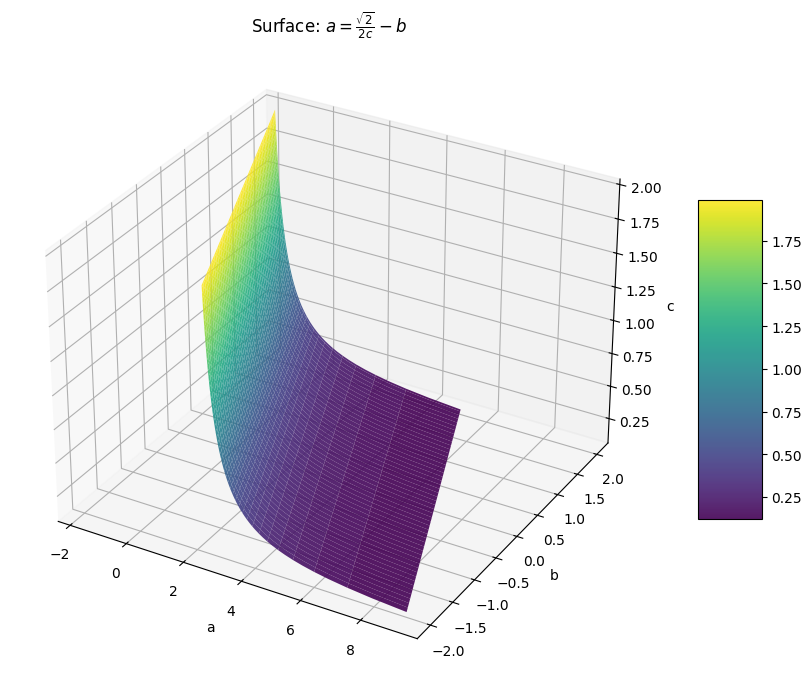

In [11]:
from sympy import solve, cancel, sqrt, Eq, nsolve, S, diag

mean_eq = 2*a0*(w0 + w1)
cov_eq = factor(cancel(cov_symm / k_2))
g3_eq = factor(cancel(g3_symm / k_3))
g4_eq = factor(cancel(g4_symm / k_4))
g5_eq = factor(cancel(g5_symm / k_5))
print(f"Mean: {mean_eq}")
print(f"Covariance: {cov_eq}")
print(f"G3: {g3_eq}")
print(f"G4: {g4_eq}")
print(f"G5: {g5_eq}")
print("\n\n")

target_mean = sqrt(2)
target_cov = 1
target_g3 = 1 / sqrt(2)
target_g4 = 1 / 2

# Define the equations to be solved
equations = [
    Eq(mean_eq, target_mean),
    Eq(cov_eq, target_cov),
    Eq(g3_eq, target_g3),
    # Eq(g4_eq, target_g4)
]

# Attempt to solve symbolically
symbolic_solution = solve(equations, (w0, w1, a0), dict=True)
print("Symbolic Solution:")
for sol in symbolic_solution:
    print(sol)
print("\n")

# Attempt to solve numerically using nsolve
try:
    numerical_solution = nsolve(equations, (w0, w1, a0), (0.1, 0.1, 0.5))
    print("\nNumerical Solution:")
    print(numerical_solution)
except Exception as e:
    print(f"Numerical Solution Failed: {e}")


# Plot of solutions in parameter space

# Create ranges for b and c
b = np.linspace(-2, 2, 100)
c = np.linspace(0.1, 2, 100)  # Avoid division by zero
B, C = np.meshgrid(b, c)

# Compute a using the equation
A = np.sqrt(2) / (2 * C) - B

# Set up 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(A, B, C, cmap='viridis', alpha=0.9, edgecolor='none')

# Label axes
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c')
ax.set_title(r'Surface: $a = \frac{\sqrt{2}}{2c} - b$')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


#### Old Code

Used for working out the case of the 'columns the same' constrained weights matrix.

In [17]:
eq_1 = (w0 - w1)**2 # from subbing mean into cov
# eq_2 = 8*(w0**4 + w1**4) - (w0 + w1)**4 # g3 no help so this is from g4
eq_2 = 32*(w0**4 - w0**3 * w1 + w0**2 * w1**2 - w0 * w1**3 + w1**4) - 2*(w0 + w1)**4


# target = 1 / (2 * sqrt(2))

eqns = [
    Eq(eq_1, 0),
    Eq(eq_2, 0)
]

# Attempt to solve symbolically
solution = solve(eqns, (w0, w1), dict=True)
print("Symbolic Solution:")
for sol in solution:
    print(sol)
print("\n")

# # Target value for G5 equation
# target = S(1) / (2 * sqrt(2))

# # Define equations to solve
# eqns = [
#     Eq(eq_1, 0),
#     Eq(eq_2, 0)
# ]

# # Provide initial guesses (You can adjust these based on your understanding of the problem)
# initial_guess = (1, 1)

# # Solve using nsolve
# try:
#     solution = nsolve(eqns, (w0, w1), initial_guess)
#     print(f"Solution using nsolve:\n w0 = {solution[0]}\n w1 = {solution[1]}")
# except Exception as e:
#     print(f"Error in solving equations: {e}")

Symbolic Solution:
{w0: w1}




### Checking Solution Validity

In [ ]:
# Input
example_mean = np.sqrt(2) * np.array([1, 1])
example_cov = 50*np.array([[1, 0], [0, 1]])

# Define variables for the 'columns same' case - not using now
x = 50
y = 1 / (2 * np.sqrt(2) * x)
layer1_col = np.array([[x, x], [x, x]])
layer2_col = np.array([[y, y]])

matrix1_col = Matrix([[x, x], [x, x]])
matrix2_col = Matrix([[y, y]])

m1_col = Array(matrix1_col.tolist())
m2_col = Array(matrix2_col.tolist())

# Define variables for the 'symmetric' case
b = 500
c = 2
a = np.sqrt(2) / (2*c) - b

layer1_symm = np.array([[a, b], [b, a]])
layer2_symm = np.array([[c, c]])

matrix1_symm = Matrix([[a, b], [b, a]])
matrix2_symm = Matrix([[c, c]])

m1_symm = Array(matrix1_symm.tolist())
m2_symm = Array(matrix2_symm.tolist())



# Affine 1
mu_z = np.matmul(layer1_symm, example_mean)
cov_z = np.matmul(np.matmul(layer1_symm, example_cov), layer1_symm.T)

G_3_new = define_diagonal_tensor((2, 2, 2), np.sqrt(2))
print(f"G_3: {G_3_new}\n")
affine_1 = tensorproduct(m1_symm, m1_symm, m1_symm, G_3_new)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
affine_1 = tensorcontraction(affine_1, (3, 4))

# Affine 2
mu_out = np.matmul(layer2_symm, mu_z)
cov_out = np.matmul(np.matmul(layer2_symm, cov_z), layer2_symm.T)

affine_2 = tensorproduct(m2_symm, m2_symm, m2_symm, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 6))
affine_2 = tensorcontraction(affine_2, (2, 5))
affine_2 = tensorcontraction(affine_2, (3, 4))

g3_new = factor(affine_2[0, 0, 0])

print(f"From the known cumulant transformation we expect: \n Mean = 2 \n Cov = 50 \n G3 = 1 \nActual outputs:\n")
print(f"Mean: {mu_out}")
print(f"Cov: {cov_out}")
print(f"G_3: {g3_new}\n")
print("  These results hold for any choice of b, c, which is consistent with my results. \n\n")


# This is for cumulants... let's check that these weights also reproduce the actual decimation transformation for some input
input = np.array([1, 7]) # output should be 4*sqrt(2)

# Affine 1
affine = np.matmul(layer1_symm, input)
output = np.matmul(layer2_symm, affine)
print(f"Double checking function output: {output} \n This is as expected, by construction.")


G_3: [[[1.4142135623731, 0], [0, 0]], [[0, 0], [0, 1.4142135623731]]]

From the known cumulant transformation we expect: 
 Mean = 2 
 Cov = 50 
 G3 = 1 
Actual outputs:

Mean: [2.]
Cov: [[50.]]
G_3: 1.00000143051147

  These results hold for any choice of b, c, which is consistent with my results. 


Double checking function output: [5.65685425] 
 This is as expected, by construction.


## MLP with 2 affine linear layers, with biases

### Define Tensors

In [12]:
k, a0, w0, w1, b1, b2 = symbols('k1 a0 w0 w1 b1 b2')
k_2, k_3, k_4, k_5, k_6 = symbols('k_2 k_3 k_4 k_5 k_6')

# Define tensors
G_1 = generate_symbolic_matrix('k', 2, 1)
G_2 = define_diagonal_tensor((2, 2), k_2)
G_3 = define_diagonal_tensor((2, 2, 2), k_3)
G_4 = define_diagonal_tensor((2, 2, 2, 2), k_4)
G_5 = define_diagonal_tensor((2, 2, 2, 2, 2), k_5)
G_6 = define_diagonal_tensor((2, 2, 2, 2, 2, 2), k_6)

# Constrain weights, using symmetry of the problem - we will use the symmetrically constrained weights as above
W_1 = Matrix([[w0, w1], [w1, w0]])
W_2 = Matrix([[a0, a0]])

W1_array = Array(W_1.tolist())
W2_array = Array(W_2.tolist())

b_1 = Matrix([[b1], [b1]])
b_2 = Matrix([[b2]])

b1_array = Array(b_1.tolist())
b2_array = Array(b_2.tolist())

G_1 = G_1.subs({
    G_1[0,0]: k,
    G_1[1,0]: k
})


print(f"Weight 1:\n{W_1}\n")
print(f"Weight 2:\n{W_2}\n")
print(f"G_1:\n{G_1}\n")
print(f"G_2:\n{G_2}\n")
print(f"G_3:\n{G_3}\n")
print(f"G_4:\n{G_4}\n")

Weight 1:
Matrix([[w0, w1], [w1, w0]])

Weight 2:
Matrix([[a0, a0]])

G_1:
Matrix([[k1], [k1]])

G_2:
[[k_2, 0], [0, k_2]]

G_3:
[[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]

G_4:
[[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]



### Propagate

In [13]:
# Mean
affine_1 = matrix_multiply(W_1, G_1) + b1_array
affine_2 = matrix_multiply(W_2, affine_1) + b2_array
mean_bias = factor(affine_2[0, 0])
print(f"Mean:\n{mean_bias}\n")

# Covariance
print(f"G_2: {G_2}")
affine_1 = tensorproduct(W1_array, W1_array, G_2)
affine_1 = tensorcontraction(affine_1, (1, 4))
affine_1 = tensorcontraction(affine_1, (2, 3)) # note that things only change for the mean

affine_2 = tensorproduct(W2_array, W2_array, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 4))
affine_2 = tensorcontraction(affine_2, (2, 3))

cov_bias = factor(affine_2[0, 0])
print(f"Covariance:\n{cov_bias}\n")

# G_3
print(f"G_3: {G_3}")
affine_1 = tensorproduct(W1_array, W1_array, W1_array, G_3)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
affine_1 = tensorcontraction(affine_1, (3, 4))

affine_2 = tensorproduct(W2_array, W2_array, W2_array, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 6))
affine_2 = tensorcontraction(affine_2, (2, 5))
affine_2 = tensorcontraction(affine_2, (3, 4))

g3_bias = factor(affine_2[0, 0, 0])
print(f"G_3:\n{g3_bias}\n")

# G_4
print(f"G_4: {G_4}")
affine_1 = tensorproduct(W1_array, W1_array, W1_array, W1_array, G_4)
affine_1 = tensorcontraction(affine_1, (1, 8))
affine_1 = tensorcontraction(affine_1, (2, 7))
affine_1 = tensorcontraction(affine_1, (3, 6))
affine_1 = tensorcontraction(affine_1, (4, 5))

affine_2 = tensorproduct(W2_array, W2_array, W2_array, W2_array, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 8))
affine_2 = tensorcontraction(affine_2, (2, 7))
affine_2 = tensorcontraction(affine_2, (3, 6))
affine_2 = tensorcontraction(affine_2, (4, 5))

g4_bias = factor(affine_2[0, 0, 0, 0])
print(f"G_4:\n{g4_bias}\n")

# G_5
print(f"G_5: {G_5}")
affine_1 = tensorproduct(W1_array, W1_array, W1_array, W1_array, W1_array, G_5)
affine_1 = tensorcontraction(affine_1, (1, 10))
affine_1 = tensorcontraction(affine_1, (2, 9))
affine_1 = tensorcontraction(affine_1, (3, 8))
affine_1 = tensorcontraction(affine_1, (4, 7))
affine_1 = tensorcontraction(affine_1, (5, 6))

affine_2 = tensorproduct(W2_array, W2_array, W2_array, W2_array, W2_array, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 10))
affine_2 = tensorcontraction(affine_2, (2, 9))
affine_2 = tensorcontraction(affine_2, (3, 8))
affine_2 = tensorcontraction(affine_2, (4, 7))
affine_2 = tensorcontraction(affine_2, (5, 6))

g5_bias = factor(affine_2[0, 0, 0, 0, 0])
print(f"G_5:\n{g5_bias}\n")

# G_6
print(f"G_6: {G_6}")
affine_1 = tensorproduct(W1_array, W1_array, W1_array, W1_array, W1_array, W1_array, G_6)
affine_1 = tensorcontraction(affine_1, (1, 12))
affine_1 = tensorcontraction(affine_1, (2, 11))
affine_1 = tensorcontraction(affine_1, (3, 10))
affine_1 = tensorcontraction(affine_1, (4, 9))
affine_1 = tensorcontraction(affine_1, (5, 8))
affine_1 = tensorcontraction(affine_1, (6, 7))

affine_2 = tensorproduct(W2_array, W2_array, W2_array, W2_array, W2_array, W2_array, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 12))
affine_2 = tensorcontraction(affine_2, (2, 11))
affine_2 = tensorcontraction(affine_2, (3, 10))
affine_2 = tensorcontraction(affine_2, (4, 9))
affine_2 = tensorcontraction(affine_2, (5, 8))
affine_2 = tensorcontraction(affine_2, (6, 7))

g6_bias = factor(affine_2[0, 0, 0, 0, 0, 0])
print(f"G_6:\n{g6_bias}\n")

Mean:
2*a0*b1 + 2*a0*k1*w0 + 2*a0*k1*w1 + b2

G_2: [[k_2, 0], [0, k_2]]
Covariance:
2*a0**2*k_2*(w0 + w1)**2

G_3: [[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]
G_3:
2*a0**3*k_3*(w0 + w1)**3

G_4: [[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]
G_4:
2*a0**4*k_4*(w0 + w1)**4

G_5: [[[[[k_5, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]], [[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_5]]]]]
G_5:
2*a0**5*k_5*(w0 + w1)**5

G_6: [[[[[[k_6, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]], [[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]]], [[[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, 0]]]], [[[[0, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_6]]]]]]
G_6:
2*a0**6*k_6*(w0 + w1)**6



### Solve

In [15]:
k_1 = symbols('k_1')
equation1 = 2*a0*(k_1*(w0 + w1) + b1) + b2 - k_1*sqrt(2)
cov_eq = factor(cancel(cov_bias / k_2))
# equation2 = (w0**2 - w1**2)
g3_eq = factor(cancel(g3_bias / k_3))
g4_eq = factor(cancel(g4_bias / k_4))
g5_eq = factor(cancel(g5_bias / k_5))
g6_eq = factor(cancel(g6_bias / k_6))
print(equation1)
print(cov_eq)
print(g3_eq)
print(g4_eq)
print(g5_eq)
print(g6_eq)
print("\n\n")

eq1_target = 0
cov_eq_target = 1
# eq2_target = 0
eq3_target = 1 / sqrt(2)
eq4_target = 1 / 2
eq5_target = 1 / (2*sqrt(2))
eq6_target = 1 / 4

    # Define the equations to be solved
equations_bias = [
    Eq(equation1, eq1_target),
    Eq(cov_eq, cov_eq_target),
    # Eq(equation2, eq2_target),
    Eq(g3_eq, eq3_target),
    Eq(g4_eq, eq4_target),
    Eq(g5_eq, eq5_target),
    # Eq(g6_eq, eq6_target)
]

# Attempt to solve symbolically
symbolic_solution = solve(equations_bias, (w0, w1, a0, b1, b2), dict=True)
print("Symbolic Solution:")
for sol in symbolic_solution:
    print(sol)
print("\n")

# # Attempt to solve numerically using nsolve
# try:
#     numerical_solution = nsolve(equations_new, (w0, w1, a0, b1, b2), (0.1, 0.1, 0.5, 1, 1))
#     print("\nNumerical Solution:")
#     print(numerical_solution)
# except Exception as e:
#     print(f"Numerical Solution Failed: {e}")

2*a0*(b1 + k_1*(w0 + w1)) + b2 - sqrt(2)*k_1
2*a0**2*(w0 + w1)**2
2*a0**3*(w0 + w1)**3
2*a0**4*(w0 + w1)**4
2*a0**5*(w0 + w1)**5
2*a0**6*(w0 + w1)**6



Symbolic Solution:
{b2: -2.0*a0*b1, w0: -w1 + 0.707106781186548/a0}




### Check Solution Validity

Verify that the above solution does indeed reproduce the correct input/output transformation, of both cumulants + standard inputs.

In [37]:
# Input
example_mean = np.sqrt(2) * np.array([1, 1])
example_cov = 50*np.array([[1, 0], [0, 1]])

G_3_new = define_diagonal_tensor((2, 2, 2), np.sqrt(2))
print(f"G_3: {G_3_new}\n")

b = 5
c = 5
d = 5
a = 1 / (np.sqrt(2) * d) - b
e = -2 * d * c

layer1_bias = np.array([[a, b], [b, a]])
layer2_bias = np.array([[d, d]])

matrix1_bias = Matrix([[a, b], [b, a]])
matrix2_bias = Matrix([[d, d]])
m1_bias = Array(matrix1_bias.tolist())
m2_bias = Array(matrix2_bias.tolist())

bias1 = np.array([c, c])
bias2 = np.array([e])

# Affine 1
mu_z = np.matmul(layer1_bias, example_mean) + bias1
cov_z = np.matmul(np.matmul(layer1_bias, example_cov), layer1_bias.T)

affine_1 = tensorproduct(m1_bias, m1_bias, m1_bias, G_3_new)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
affine_1 = tensorcontraction(affine_1, (3, 4))

# Affine 2
mu_out = np.matmul(layer2_bias, mu_z) + bias2
cov_out = np.matmul(np.matmul(layer2_bias, cov_z), layer2_bias.T)

affine_2 = tensorproduct(m2_bias, m2_bias, m2_bias, affine_1)
affine_2 = tensorcontraction(affine_2, (1, 6))
affine_2 = tensorcontraction(affine_2, (2, 5))
affine_2 = tensorcontraction(affine_2, (3, 4))

g3_new = factor(affine_2[0, 0, 0])

# Print results
print(f"From the known cumulant transformation we expect: \n Mean = 2 \n Cov = 50 \n G3 = 1 \nActual outputs:\n")
print(f"Mean: {mu_out}")
print(f"Cov: {cov_out}")
print(f"G_3: {g3_new}\n")
print("  These results hold for any choice of b, c, d, which is consistent with my results. \n\n")


# The above is for cumulants... let's check that these weights also reproduce the actual decimation transformation for some input
input = np.array([1, 7]) # output should be 4*sqrt(2)

# Affine 1
affine = np.matmul(layer1_bias, input) + bias1
output = np.matmul(layer2_bias, affine) + bias2
print(f"Double checking function output: {output} \n This is as expected, by construction.")


G_3: [[[1.4142135623731, 0], [0, 0]], [[0, 0], [0, 1.4142135623731]]]

From the known cumulant transformation we expect: 
 Mean = 2 
 Cov = 50 
 G3 = 1 
Actual outputs:

Mean: [2.]
Cov: [[50.]]
G_3: 0.999999999997726

  These results hold for any choice of b, c, d, which is consistent with my results. 


Double checking function output: [5.65685425] 
 This is as expected, by construction.


## 2 affine, 1 nonlinearity

### Define Tensors

In [28]:
a0, w0, w1 = symbols('a0 w0 w1')
k_1, k_2, k_3, k_4, k_5 = symbols('k_1 k_2 k_3 k_4 k_5')
w2, w3, a1 = symbols('w2 w3 a1')

# Define tensors
G_1 = generate_symbolic_matrix('k', 2, 1)
G_2 = define_diagonal_tensor((2, 2), k_2)
G_3 = define_diagonal_tensor((2, 2, 2), k_3)
G_4 = define_diagonal_tensor((2, 2, 2, 2), k_4)
G_5 = define_diagonal_tensor((2, 2, 2, 2, 2), k_5)

G_1 = G_1.subs({
    G_1[0,0]: k_1,
    G_1[1,0]: k_1
})

# Constrain weights, using symmetry of the problem
W_1 = Matrix([[w0, w1], [w1, w0]]) # change to use the symmetric matrix, better
W_2 = Matrix([[a0, a0]])

W1_array = Array(W_1.tolist())
W2_array = Array(W_2.tolist())

# Define new variables, now allowing for any weights
W_1_free = Matrix([[w0, w1], [w2, w3]])
W_2_free = Matrix([[a0, a1]])

W1_array_free = Array(W_1_free.tolist())
W2_array_free = Array(W_2_free.tolist())
print(f"Weight 1 (free):\n{W_1_free}\n")
print(f"Weight 2 (free):\n{W_2_free}\n")


print(f"Weight 1 (constrained):\n{W_1}\n")
print(f"Weight 2 (constrained):\n{W_2}\n")
print(f"G_1:\n{G_1}\n")
print(f"G_2:\n{G_2}\n")
print(f"G_3:\n{G_3}\n")
print(f"G_4:\n{G_4}\n")

Weight 1 (free):
Matrix([[w0, w1], [w2, w3]])

Weight 2 (free):
Matrix([[a0, a1]])

Weight 1 (constrained):
Matrix([[w0, w1], [w1, w0]])

Weight 2 (constrained):
Matrix([[a0, a0]])

G_1:
Matrix([[k_1], [k_1]])

G_2:
[[k_2, 0], [0, k_2]]

G_3:
[[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]

G_4:
[[[[k_4, 0], [0, 0]], [[0, 0], [0, 0]]], [[[0, 0], [0, 0]], [[0, 0], [0, k_4]]]]



### Propagate Across 1st Linear Layer

In [29]:
# Mean
mean_a1 = matrix_multiply(W1_array, G_1)
print(f"Mean after affine 1:\n{mean_a1}\n")

# Covariance
print(f"G_2: {G_2}")
affine_1 = tensorproduct(W1_array, W1_array, G_2)
affine_1 = tensorcontraction(affine_1, (1, 4))
cov_a1 = tensorcontraction(affine_1, (2, 3))
print(f"Covariance after affine 1:\n{cov_a1}\n")

# G_3
print(f"G_3: {G_3}")
affine_1 = tensorproduct(W1_array, W1_array, W1_array, G_3)
affine_1 = tensorcontraction(affine_1, (1, 6))
affine_1 = tensorcontraction(affine_1, (2, 5))
g3_a1 = tensorcontraction(affine_1, (3, 4))
print(f"G_3 after affine 1:\n{g3_a1}\n")


Mean after affine 1:
[[k_1*w0 + k_1*w1], [k_1*w0 + k_1*w1]]

G_2: [[k_2, 0], [0, k_2]]
Covariance after affine 1:
[[k_2*w0**2 + k_2*w1**2, 2*k_2*w0*w1], [2*k_2*w0*w1, k_2*w0**2 + k_2*w1**2]]

G_3: [[[k_3, 0], [0, 0]], [[0, 0], [0, k_3]]]
G_3 after affine 1:
[[[k_3*w0**3 + k_3*w1**3, k_3*w0**2*w1 + k_3*w0*w1**2], [k_3*w0**2*w1 + k_3*w0*w1**2, k_3*w0**2*w1 + k_3*w0*w1**2]], [[k_3*w0**2*w1 + k_3*w0*w1**2, k_3*w0**2*w1 + k_3*w0*w1**2], [k_3*w0**2*w1 + k_3*w0*w1**2, k_3*w0**3 + k_3*w1**3]]]



### Nonlinearity
Using the Fisher gaussian approx

Weights will be such that the Fisher framework version of the network will implement the Laplace cumulant evolution properly.

In [35]:
from sympy import simplify, factor, collect

alpha = symbols('A')

def apply_quadratic_nonlinearity(mu_z, cov_z):
    # Convert mu_z to a Matrix if it's an Array
    if isinstance(mu_z, Array):
        mu_z = Matrix(mu_z.tolist())

    dim = mu_z.shape[0]
    
    # Extract diagonal entries of cov_z as a column vector
    diag_cov_z = Matrix([cov_z[i, i] for i in range(dim)])
    
    # Update mean (using applyfunc to apply element-wise squaring)
    mu_y = mu_z + alpha * (mu_z.applyfunc(lambda x: x**2) + diag_cov_z)
    
    # Update covariance
    cov_y = Matrix.zeros(dim, dim)
    for i in range(dim):
        for j in range(dim):
            sigma_z_ij = cov_z[i, j]
            mu_z_i = mu_z[i]
            mu_z_j = mu_z[j]

            cov_y[i, j] = (
                sigma_z_ij
                + 2 * alpha * sigma_z_ij * (mu_z_i + mu_z_j)
                + 2 * alpha**2 * (sigma_z_ij)**2
                + 4 * alpha**2 * mu_z_i * mu_z_j * sigma_z_ij
            )
    
    mu_y = Array(mu_y.tolist())
    cov_y = Array(cov_y.tolist())

    return mu_y, cov_y


# Apply nonlinearity
mu_y, cov_y = apply_quadratic_nonlinearity(mean_a1, cov_a1)
factored_mu_y = [[collect(expr, [A, k_1, k_2, (w0+w1)]) for expr in row] for row in mu_y.tolist()]


print("Updated Mean:\n", mu_y)
print("Factored Updated Mean:\n", factored_mu_y)
print("Updated Covariance:\n", cov_y)


Updated Mean:
 [[A*(k_2*w0**2 + k_2*w1**2 + (k_1*w0 + k_1*w1)**2) + k_1*w0 + k_1*w1], [A*(k_2*w0**2 + k_2*w1**2 + (k_1*w0 + k_1*w1)**2) + k_1*w0 + k_1*w1]]
Factored Updated Mean:
 [[A*(k_1**2*(w0 + w1)**2 + k_2*(w0**2 + w1**2)) + k_1*(w0 + w1)], [A*(k_1**2*(w0 + w1)**2 + k_2*(w0**2 + w1**2)) + k_1*(w0 + w1)]]
Updated Covariance:
 [[4*A**2*(k_1*w0 + k_1*w1)**2*(k_2*w0**2 + k_2*w1**2) + 2*A**2*(k_2*w0**2 + k_2*w1**2)**2 + 2*A*(2*k_1*w0 + 2*k_1*w1)*(k_2*w0**2 + k_2*w1**2) + k_2*w0**2 + k_2*w1**2, 8*A**2*k_2**2*w0**2*w1**2 + 8*A**2*k_2*w0*w1*(k_1*w0 + k_1*w1)**2 + 4*A*k_2*w0*w1*(2*k_1*w0 + 2*k_1*w1) + 2*k_2*w0*w1], [8*A**2*k_2**2*w0**2*w1**2 + 8*A**2*k_2*w0*w1*(k_1*w0 + k_1*w1)**2 + 4*A*k_2*w0*w1*(2*k_1*w0 + 2*k_1*w1) + 2*k_2*w0*w1, 4*A**2*(k_1*w0 + k_1*w1)**2*(k_2*w0**2 + k_2*w1**2) + 2*A**2*(k_2*w0**2 + k_2*w1**2)**2 + 2*A*(2*k_1*w0 + 2*k_1*w1)*(k_2*w0**2 + k_2*w1**2) + k_2*w0**2 + k_2*w1**2]]


### Propagate Across 2nd Linear Layer

In [ ]:
# Mean
mean_a2 = matrix_multiply(W_2_free, mu_y)
mean_a2 = factor(mean_a2[0, 0])
print(f"Mean: {mean_a2}\n")

# Covariance
print(f"G_2: {G_2}")
affine_2 = tensorproduct(W2_array_free, W2_array_free, cov_y)
affine_2 = tensorcontraction(affine_2, (1, 4))
affine_2 = tensorcontraction(affine_2, (2, 3))

cov_a2 = factor(affine_2[0, 0])
print(f"Covariance:\n{cov_a2}\n")

# print(f"Simplified:\n {factor(cov_a2)}\n")
# # G_3
# print(f"G_3: {G_3}")
# affine_2 = tensorproduct(W2_array, W2_array, W2_array, affine_1)
# affine_2 = tensorcontraction(affine_2, (1, 6))
# affine_2 = tensorcontraction(affine_2, (2, 5))
# affine_2 = tensorcontraction(affine_2, (3, 4))

# g3 = factor(affine_2[0, 0, 0])
# print(f"G_3:\n{g3}\n")


print("\nNow trying to factorise....:")
# Step 1: Factor out common terms
cov_a2_factored = factor(cov_a2)

# Step 2: Collect like terms by a few important variables (e.g., k1, k2)
cov_a2_collected_k1 = collect(cov_a2_factored, k_1)
cov_a2_collected_k2 = collect(cov_a2_factored, k_2)

# Step 3: Apply general simplification
cov_a2_simplified_k1 = simplify(cov_a2_collected_k1)
cov_a2_simplified_k2 = simplify(cov_a2_collected_k2)

print(f"{cov_a2_simplified_k1}\n")
print(f"{cov_a2_simplified_k2}\n")

Mean: (a0 + a1)*(A*k_1**2*w0**2 + 2*A*k_1**2*w0*w1 + A*k_1**2*w1**2 + A*k_2*w0**2 + A*k_2*w1**2 + k_1*w0 + k_1*w1)

G_2: [[k_2, 0], [0, k_2]]
Covariance:
k_2*(a0 + a1)**2*(w0**2 + w1**2)*(4*A**2*k_1**2*w0**2 + 8*A**2*k_1**2*w0*w1 + 4*A**2*k_1**2*w1**2 + 2*A**2*k_2*w0**2 + 2*A**2*k_2*w1**2 + 4*A*k_1*w0 + 4*A*k_1*w1 + 1)


Now trying to factorise....:
k_2*(a0 + a1)**2*(w0**2 + w1**2)*(4*A**2*k_1**2*(w0**2 + 2*w0*w1 + w1**2) + 2*A**2*k_2*w0**2 + 2*A**2*k_2*w1**2 + 4*A*k_1*(w0 + w1) + 1)

k_2*(a0 + a1)**2*(w0**2 + w1**2)*(4*A**2*k_1**2*w0**2 + 8*A**2*k_1**2*w0*w1 + 4*A**2*k_1**2*w1**2 + 2*A**2*k_2*(w0**2 + w1**2) + 4*A*k_1*w0 + 4*A*k_1*w1 + 1)



### Solve eqns

In [ ]:
mean_cancel = factor(cancel(mean_a2 / k_1))
cov_cancel = factor(cancel(cov_a2 / k_2))

print(mean_cancel)
print(cov_cancel)
print("\n\n")

# Set a0=1 manually
mean_simp = 2.0*(0.5*k_1**2*w0**2 + 1.0*k_1**2*w0*w1 + 0.5*k_1**2*w1**2 + 1.0*k_1*w0 + 1.0*k_1*w1 + 0.5*k_2*w0**2 + 0.5*k_2*w1**2)
cov_simp = 8.0**k_2*(1.0*w0**2 + 1.0*w1**2)*(0.5*k_1**2*w0**2 + 1.0*k_1**2*w0*w1 + 0.5*k_1**2*w1**2 + 1.0*k_1*w0 + 1.0*k_1*w1 + 0.25*k_2*w0**2 + 0.25*k_2*w1**2 + 0.5)

mean_target = sqrt(2)
cov_target = 1

# Define the equations to be solved
equations = [
    Eq(mean_simp, mean_target),
    Eq(cov_simp, cov_target)
]

(A*a0*k_1**2*w0**2 + 2*A*a0*k_1**2*w0*w1 + A*a0*k_1**2*w1**2 + A*a0*k_2*w0**2 + A*a0*k_2*w1**2 + A*a1*k_1**2*w2**2 + 2*A*a1*k_1**2*w2*w3 + A*a1*k_1**2*w3**2 + A*a1*k_2*w2**2 + A*a1*k_2*w3**2 + a0*k_1*w0 + a0*k_1*w1 + a1*k_1*w2 + a1*k_1*w3)/k_1
4*A**2*a0**2*k_1**2*w0**4 + 8*A**2*a0**2*k_1**2*w0**3*w1 + 8*A**2*a0**2*k_1**2*w0**2*w1**2 + 8*A**2*a0**2*k_1**2*w0*w1**3 + 4*A**2*a0**2*k_1**2*w1**4 + 2*A**2*a0**2*k_2*w0**4 + 4*A**2*a0**2*k_2*w0**2*w1**2 + 2*A**2*a0**2*k_2*w1**4 + 8*A**2*a0*a1*k_1**2*w0**2*w2**2 + 8*A**2*a0*a1*k_1**2*w0**2*w2*w3 + 8*A**2*a0*a1*k_1**2*w0*w1*w2**2 + 16*A**2*a0*a1*k_1**2*w0*w1*w2*w3 + 8*A**2*a0*a1*k_1**2*w0*w1*w3**2 + 8*A**2*a0*a1*k_1**2*w1**2*w2*w3 + 8*A**2*a0*a1*k_1**2*w1**2*w3**2 + 4*A**2*a0*a1*k_2*w0**2*w2**2 + 8*A**2*a0*a1*k_2*w0*w1*w2*w3 + 4*A**2*a0*a1*k_2*w1**2*w3**2 + 4*A**2*a1**2*k_1**2*w2**4 + 8*A**2*a1**2*k_1**2*w2**3*w3 + 8*A**2*a1**2*k_1**2*w2**2*w3**2 + 8*A**2*a1**2*k_1**2*w2*w3**3 + 4*A**2*a1**2*k_1**2*w3**4 + 2*A**2*a1**2*k_2*w2**4 + 4*A**2*a1**2*k

### Comments

The code for the propagation across the nonlinearity is actually only set up for the Gaussian approximation, rather than the full explicit thing that relies on cumulants up to 4th order. Therefore, it isn't directly that useful to solve for weights that implement the true function, rather it would yield weights that implement an approximation to the true function only.

Ended up solving this by hand anyway with just a consideration of the mean, and by comparing coefficients, bypassing the need for most of this section.